# Decision Tree

In [1]:
import os
def savefig(fig, name):
    if not os.path.exists('images'):
        os.makedirs('images')
    fig.savefig('images/' + name + '.png')

import matplotlib.pyplot as plt
import numpy as np

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

## Introduction

Decision tree are versatile machine learning algorithms that can perform both `classification` and `regression tasks`, and even `multioutput` tasks. They capable of `fitting complex datasets`.

Decision tree are the fundamental components of RandomForest.


## Training and Visualizing a Decision Tree

In [2]:
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier

iris = load_iris(as_frame=True)
X_iris = iris.data[["petal length (cm)", "petal width (cm)"]].values
y_iris = iris.target

tree_clf = DecisionTreeClassifier(max_depth=2, random_state=42)
tree_clf.fit(X_iris, y_iris)

DecisionTreeClassifier(max_depth=2, random_state=42)

### Visualizing the trained decision tree by using `export_graphviz()`

In [3]:
from sklearn.tree import export_graphviz

export_graphviz(
    tree_clf,
    out_file="iris_tree.dot",
    feature_names=["petal length (cm)", "petal width (cm)"],
    class_names=iris.target_names,
    rounded=True,
    filled=True
)

In [4]:
from graphviz import Source

s1 = Source.from_file("iris_tree.dot")

![images](images/source1.png)

First, the root node asks whether the flower's petal length is smaller than 2.45 cm. If `true`, you will `move down to left child node`. In this case, it is a `leaf node`, so it does not ask any questions and predicts that your flower is **setosa**.

Now suppose you fine another flower, and this time the petal length is `greater than 2.45 cm`. You will `move down to right child node`. Because it is not a leaf child, so it asks another question... until you move to left child.

**One of the many qualities** of decision tree is that they require very little data preparation. In fact, thay don't require feature scaling or centering at all.

A node's `sample` attribute `counts how many training instances` it applies to. For example: 100 training instances have a petal length greater than 2.45 cm (depth 1 right), 54 have a petal width smaller than 1.75 cm (depth 2, left).

A node's `value` attribute `tells you how many training instances of each class this node applies to`. For example: At bottom-right node applies 0 Iris setosa, 1 Iris verisicolor, 45 Iris virginica.

Finally, a node's `gini` attribute measures its `Gini impurity`: A node is "pure" when all training instances it applies to belong to the same class. For example: The (depth 1, left): all training instaces belong to the same class, so the gini equals to 0.

Equation shows how the training algorithm computes the Gini impurity $G_i$ of the $i^{th}$ node:

$$
G_i  = 1 - \sum_{k=1}^{n} p_{i, k}^2 \tag{6-1}
$$

In this equation:

- $G_i$ is the Gini impurity of the $i^{th}$ node.
- $p_{i,k}$ is the ratio of class $k$ instances among the training instances in the $i^{th}$ node.

## Making Predictions

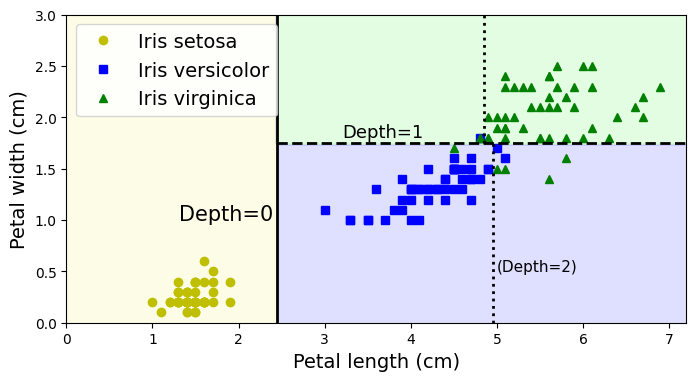

In [5]:
import numpy as np
import matplotlib.pyplot as plt

from matplotlib.colors import ListedColormap
custom_cmap = ListedColormap(['#fafab0', '#9898ff', '#a0faa0'])
plt.figure(figsize=(8, 4))

lengths, widths = np.meshgrid(np.linspace(0, 7.2, 100), np.linspace(0, 3, 100))
X_iris_all = np.c_[lengths.ravel(), widths.ravel()]
y_pred = tree_clf.predict(X_iris_all).reshape(lengths.shape)
plt.contourf(lengths, widths, y_pred, alpha=0.3, cmap=custom_cmap)
for idx, (name, style) in enumerate(zip(iris.target_names, ("yo", "bs", "g^"))):
    plt.plot(X_iris[:, 0][y_iris == idx], X_iris[:, 1][y_iris == idx],
             style, label=f"Iris {name}")

tree_clf_deeper = DecisionTreeClassifier(max_depth=3, random_state=42)
tree_clf_deeper.fit(X_iris, y_iris)
th0, th1, th2a, th2b = tree_clf_deeper.tree_.threshold[[0, 2, 3, 6]]
plt.xlabel("Petal length (cm)")
plt.ylabel("Petal width (cm)")
plt.plot([th0, th0], [0, 3], "k-", linewidth=2)
plt.plot([th0, 7.2], [th1, th1], "k--", linewidth=2)
plt.plot([th2a, th2a], [0, th1], "k:", linewidth=2)
plt.plot([th2b, th2b], [th1, 3], "k:", linewidth=2)
plt.text(th0 - 0.05, 1.0, "Depth=0", horizontalalignment="right", fontsize=15)
plt.text(3.2, th1 + 0.02, "Depth=1", verticalalignment="bottom", fontsize=13)
plt.text(th2a + 0.05, 0.5, "(Depth=2)", fontsize=11)
plt.axis([0, 7.2, 0, 3])
plt.legend()
savefig(plt, "decision_tree_decision_boundaries_plot")

plt.show()

### Note Model Interpretation: White Box versus Black Box

Decision trees are intuitive, and their decision are easy to interpret. Such model are often called `white box` models. In contrast, `random forest` and `neural networks` are generally considered `black box` models. They make `great predictions`, you can easily `check the calculations` that they performed to make these predictions; But, it is usually `hard to explain` in simple terms `why the predictions were made`. Conversely, decision trees provide nice, simple classification rules that can even be `applied manually` if need be. The
field of interpretable ML aims at creating ML systems that can explain their decisions in `a way humans can understand`.

## Estimate Class Pobabilities

A decision tree `can estimate the probability` that an instance belongs to an particular class $k$. First `it traverses the tree to find the leaf node` for this instance, and then it `returns the ratio of training instances` of class $k$ in this node.

In [6]:
tree_clf.predict_proba([[5, 1.5]]).round(3)

array([[0.   , 0.907, 0.093]])

In [7]:
tree_clf.predict([[5, 1.5]])

array([1])

## The CART Training Algorithm

Scikit-learn uses the `Classification and Regression Tree` (CART) algorithm to train decision trees (also called "growing" trees). The algorithm works bt `first splitting the training set into two subsets` using a single features $k$ and threshold $t_k$ (ex: "petal length $\leq$ 2.45 cm). How does it choose $k$ and $t_k$. Equation 6-2 gives `the cost function` that the algorithm tries to minimize:

$$
\begin{aligned}&J(k,t_{k})=\frac{m_{\mathrm{left}}}{m}G_{\mathrm{left}}+\frac{m_{\mathrm{right}}}{m}G_{\mathrm{right}}\\&\mathrm{where~}\begin{cases}G_{\mathrm{left/right}}\text{ measures the impurity of the left/right subset}\\m_{\mathrm{left/right}}\text{ is the number of instances in the left/right subset}\end{cases}\end{aligned} \tag{6-2}
$$

Once the CART algorithm splits successfully, it splits the subsets using `the same logic`, then sub-subsets, and so on, `recusively`. It `stops recursing` once it `reaches the maximum depth`, or if it `cannot find a split that will reduce impurity`.


### Note

As you can see, the CART algorithm is a `greedy algorithm` (tham lam). It often returns a `solution that's reasonably good` but `not guaranteed to be optimal`.

Unfortunately, finding the optimal tree is known to be an NP complete problem. It requires `O(exp(m))` times, making the problem intracable even for small training sets.

## Regularization Hyperparameters

Decision trees make very few of assumptions about the training data (as opposed to linear models, which assume that the data is linear). If left unconstrained,
the tree structure will adapt itself to the training data, `fitting it very closely`. $\to$ `overfitting`. Such a model is often called a `nonparametric model`. Not because it does not have any parameters but because `the number of parameters is not determined prior to training`, so the model structure is `free to stick closely to the data`. To avoid overfitting the training data, you need to restrict decision tree's freedom during training. $\to$ Reducing `max_depth` hyperparameter will regularize the model and thus `reduce the risk of overfitting`.

The DecisionTreeClassifier class has a few other parameters that similarly restrict the shape of the decision tree:

- `max_features`: Maximum number of features that are evaluated for splitting at each node

- `max_leaf_nodes`: Maximum number of leaf nodes

- `min_samples_split`: Minimum number of samples a node must have before it can be split

- `min_samples_leaf`: Minimum number of samples a leaf node must have to be created

- `min_weight_fraction_leaf`: Same as `min_samples_leaf` but expressed as a fraction of the total number of weighted instances

>Increasing `min_*` hyperparameters or reducing `max_*` hyperparameters will regularize the model


In [8]:
from sklearn.datasets import make_moons

X_moons, y_moons = make_moons(n_samples=150, noise=0.2, random_state=42)

tree_clf1 = DecisionTreeClassifier(random_state=42)
tree_clf2 = DecisionTreeClassifier(min_samples_leaf=5, random_state=42)

tree_clf1.fit(X_moons, y_moons)
tree_clf2.fit(X_moons, y_moons)

DecisionTreeClassifier(min_samples_leaf=5, random_state=42)

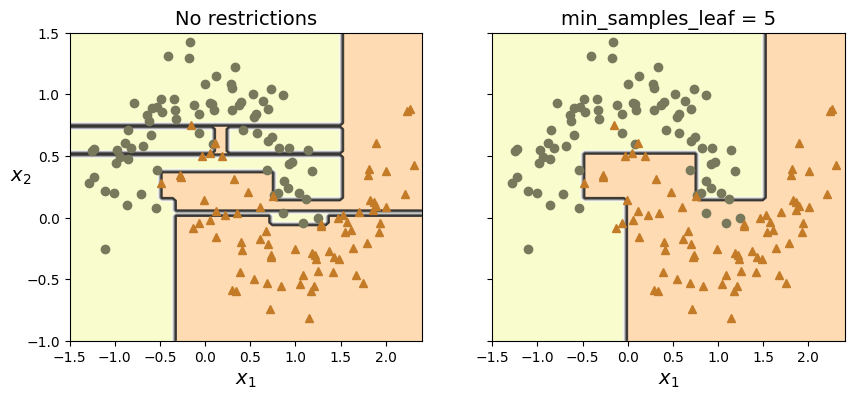

In [9]:
def plot_decision_boundary(clf, X, y, axes, cmap):
    x1, x2 = np.meshgrid(np.linspace(axes[0], axes[1], 100),
                         np.linspace(axes[2], axes[3], 100))
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)

    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=cmap)
    plt.contour(x1, x2, y_pred, cmap="Greys", alpha=0.8)
    colors = {"Wistia": ["#78785c", "#c47b27"], "Pastel1": ["red", "blue"]}
    markers = ("o", "^")
    for idx in (0, 1):
        plt.plot(X[:, 0][y == idx], X[:, 1][y == idx],
                 color=colors[cmap][idx], marker=markers[idx], linestyle="none")
    plt.axis(axes)
    plt.xlabel(r"$x_1$")
    plt.ylabel(r"$x_2$", rotation=0)

fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)
plt.sca(axes[0])
plot_decision_boundary(tree_clf1, X_moons, y_moons,
                       axes=[-1.5, 2.4, -1, 1.5], cmap="Wistia")
plt.title("No restrictions")
plt.sca(axes[1])
plot_decision_boundary(tree_clf2, X_moons, y_moons,
                       axes=[-1.5, 2.4, -1, 1.5], cmap="Wistia")
plt.title(f"min_samples_leaf = {tree_clf2.min_samples_leaf}")
plt.ylabel("")
savefig(plt, "min_samples_leaf_plot")
plt.show()

The unregularized model on the left is clearly overfitting, and the regularized model on the right will probably generalize better.

In [10]:
X_moons_test, y_moons_test = make_moons(n_samples=1000, noise=0.2, random_state=43)
tree_clf1.score(X_moons_test, y_moons_test)


0.898

In [11]:
tree_clf2.score(X_moons_test, y_moons_test)


0.92

## Regression

In [12]:
from sklearn.tree import DecisionTreeRegressor

np.random.seed(42)
X_quad = np.random.rand(200, 1) - 0.5  # a single random input feature
y_quad = X_quad ** 2 + 0.025 * np.random.randn(200, 1)

tree_reg = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg.fit(X_quad, y_quad)

DecisionTreeRegressor(max_depth=2, random_state=42)

In [13]:
export_graphviz(
    tree_reg,
    out_file="regression_tree.dot",
    feature_names=["x1"],
    rounded=True,
    filled=True
)

In [14]:
s = Source.from_file("regression_tree.dot")

![image.png](images/source2.png)

This tree look very similar to the classification tree. The main difference is that instead of predicting a class of each node, it predicts a value. For example: suppose you want to make a prediction for a new instance $x_1 = -0.3$. The root node asks whether $x_1 \leq -0.303$..... like classification tree.

In [15]:
tree_reg2 = DecisionTreeRegressor(max_depth=3, random_state=42)
tree_reg2.fit(X_quad, y_quad)

DecisionTreeRegressor(max_depth=3, random_state=42)

In [16]:
tree_reg.tree_.threshold

array([-0.30265072, -0.40830374, -2.        , -2.        ,  0.27175756,
       -2.        , -2.        ])

In [17]:
tree_reg2.tree_.threshold

array([-0.30265072, -0.40830374, -0.45416115, -2.        , -2.        ,
       -0.37022041, -2.        , -2.        ,  0.27175756, -0.21270403,
       -2.        , -2.        ,  0.40399227, -2.        , -2.        ])

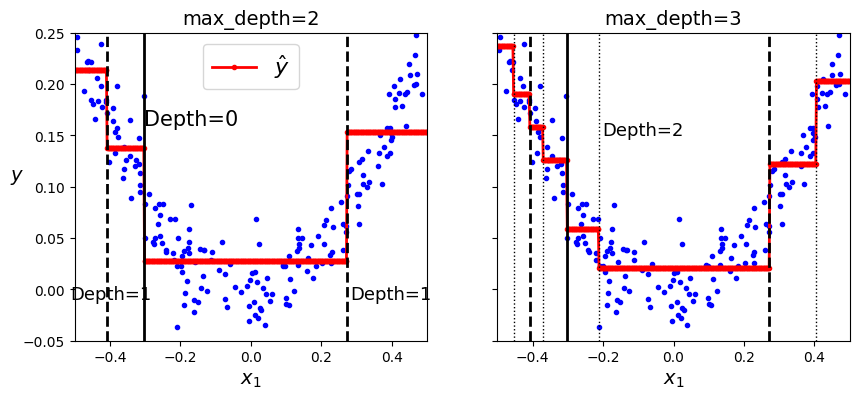

In [18]:
def plot_regression_predictions(tree_reg, X, y, axes=[-0.5, 0.5, -0.05, 0.25]):
    x1 = np.linspace(axes[0], axes[1], 500).reshape(-1, 1)
    y_pred = tree_reg.predict(x1)
    plt.axis(axes)
    plt.xlabel("$x_1$")
    plt.plot(X, y, "b.")
    plt.plot(x1, y_pred, "r.-", linewidth=2, label=r"$\hat{y}$")

fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)
plt.sca(axes[0])
plot_regression_predictions(tree_reg, X_quad, y_quad)

th0, th1a, th1b = tree_reg.tree_.threshold[[0, 1, 4]]
for split, style in ((th0, "k-"), (th1a, "k--"), (th1b, "k--")):
    plt.plot([split, split], [-0.05, 0.25], style, linewidth=2)
plt.text(th0, 0.16, "Depth=0", fontsize=15)
plt.text(th1a + 0.01, -0.01, "Depth=1", horizontalalignment="center", fontsize=13)
plt.text(th1b + 0.01, -0.01, "Depth=1", fontsize=13)
plt.ylabel("$y$", rotation=0)
plt.legend(loc="upper center", fontsize=16)
plt.title("max_depth=2")

plt.sca(axes[1])
th2s = tree_reg2.tree_.threshold[[2, 5, 9, 12]]
plot_regression_predictions(tree_reg2, X_quad, y_quad)
for split, style in ((th0, "k-"), (th1a, "k--"), (th1b, "k--")):
    plt.plot([split, split], [-0.05, 0.25], style, linewidth=2)
for split in th2s:
    plt.plot([split, split], [-0.05, 0.25], "k:", linewidth=1)
plt.text(th2s[2] + 0.01, 0.15, "Depth=2", fontsize=13)
plt.title("max_depth=3")

# savefig(plt, "tree_regression_plot")
plt.show()

The cost function of DecisionTreeRegressor

$$
J(k,t_k)=\frac{m_{\mathrm{left}}}{m}\mathrm{MSE}_{\mathrm{left}}+\frac{m_{\mathrm{right}}}{m}\mathrm{MSE}_{\mathrm{right}}\quad\mathrm{where}\quad\begin{cases}\mathrm{MSE}_{\mathrm{node}}=\frac{\Sigma_{i \in node}\left(\hat{y}_{\mathrm{node}}-y^{(i)}\right)^2}{m_{\mathrm{node}}}\\\widehat{y}_{\mathrm{node}}=\frac{\Sigma_{i \in node}y^{(i)}}{m_{\mathrm{node}}}\end{cases} \tag{6-4}
$$

Like classification tasks, decision tree are prone to overfitting when dealing with regression task. Withou any regularization, you get the predictions on the left in Figure below. These predictions are obviously overfitting the training set. Just setting `min_samples_leaf=10` results in a much more reasonable model, represented on the right of the figure.

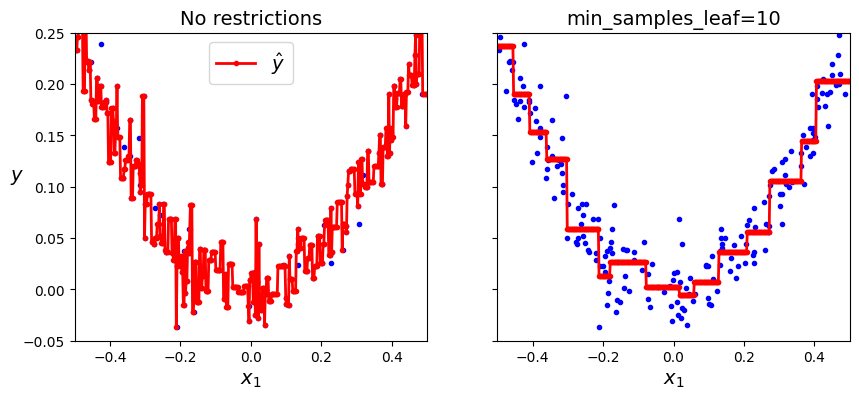

In [19]:
tree_reg1 = DecisionTreeRegressor(random_state=42)
tree_reg2 = DecisionTreeRegressor(random_state=42, min_samples_leaf=10)
tree_reg1.fit(X_quad, y_quad)
tree_reg2.fit(X_quad, y_quad)

x1 = np.linspace(-0.5, 0.5, 500).reshape(-1, 1)
y_pred1 = tree_reg1.predict(x1)
y_pred2 = tree_reg2.predict(x1)

fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)

plt.sca(axes[0])
plt.plot(X_quad, y_quad, "b.")
plt.plot(x1, y_pred1, "r.-", linewidth=2, label=r"$\hat{y}$")
plt.axis([-0.5, 0.5, -0.05, 0.25])
plt.xlabel("$x_1$")
plt.ylabel("$y$", rotation=0)
plt.legend(loc="upper center")
plt.title("No restrictions")

plt.sca(axes[1])
plt.plot(X_quad, y_quad, "b.")
plt.plot(x1, y_pred2, "r.-", linewidth=2, label=r"$\hat{y}$")
plt.axis([-0.5, 0.5, -0.05, 0.25])
plt.xlabel("$x_1$")
plt.title(f"min_samples_leaf={tree_reg2.min_samples_leaf}")

savefig(plt, "tree_regression_regularization_plot")
plt.show()

## Sensitive to axis orientation

Look at the figure below: On the left, a decision tree can split data easily, while on the right, after the dataset is rotated 45°, the decision boundary looks unnecessarily convoluted. Although both decision trees fit the training set perfectly, it is very likely that the model on the right will not generalize well.

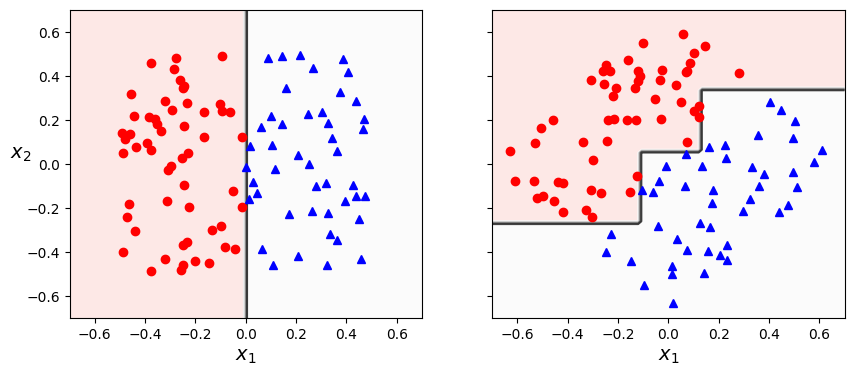

In [20]:
np.random.seed(6)
X_square = np.random.rand(100, 2) - 0.5
y_square = (X_square[:, 0] > 0).astype(np.int64)

angle = np.pi / 4  # 45 degrees
rotation_matrix = np.array([[np.cos(angle), -np.sin(angle)],
                            [np.sin(angle), np.cos(angle)]])
X_rotated_square = X_square.dot(rotation_matrix)

tree_clf_square = DecisionTreeClassifier(random_state=42)
tree_clf_square.fit(X_square, y_square)
tree_clf_rotated_square = DecisionTreeClassifier(random_state=42)
tree_clf_rotated_square.fit(X_rotated_square, y_square)

fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)
plt.sca(axes[0])
plot_decision_boundary(tree_clf_square, X_square, y_square,
                       axes=[-0.7, 0.7, -0.7, 0.7], cmap="Pastel1")
plt.sca(axes[1])
plot_decision_boundary(tree_clf_rotated_square, X_rotated_square, y_square,
                       axes=[-0.7, 0.7, -0.7, 0.7], cmap="Pastel1")
plt.ylabel("")

savefig(plt, "sensitivity_to_rotation_plot")
plt.show()

One way to limit this problem is to `scale the data`, then `apply a principal component analysis` transformation. Only need to know `it rotates the data in a way` that `reduces the correlation between the features`, which often (not always) makes things easier for trees.

In [21]:
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

pca_pipeline = make_pipeline(
    StandardScaler(),
    PCA()
)

X_iris_rotated = pca_pipeline.fit_transform(X_iris)
tree_clf_pca = DecisionTreeClassifier(max_depth=2, random_state=42)
tree_clf_pca.fit(X_iris_rotated, y_iris)

DecisionTreeClassifier(max_depth=2, random_state=42)

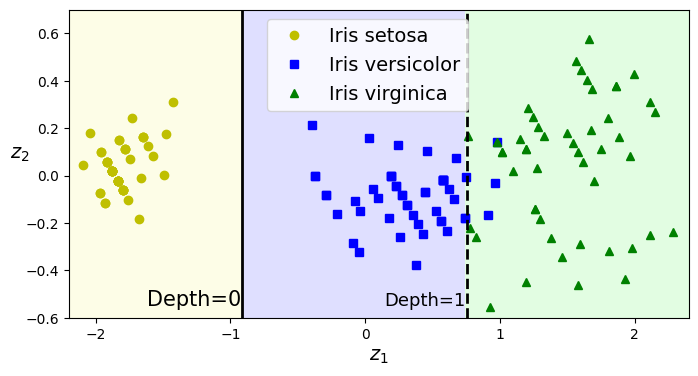

In [22]:
plt.figure(figsize=(8, 4))

axes = [-2.2, 2.4, -0.6, 0.7]
z0s, z1s = np.meshgrid(np.linspace(axes[0], axes[1], 100),
                       np.linspace(axes[2], axes[3], 100))
X_iris_pca_all = np.c_[z0s.ravel(), z1s.ravel()]
y_pred = tree_clf_pca.predict(X_iris_pca_all).reshape(z0s.shape)

plt.contourf(z0s, z1s, y_pred, alpha=0.3, cmap=custom_cmap)
for idx, (name, style) in enumerate(zip(iris.target_names, ("yo", "bs", "g^"))):
    plt.plot(X_iris_rotated[:, 0][y_iris == idx],
             X_iris_rotated[:, 1][y_iris == idx],
             style, label=f"Iris {name}")

plt.xlabel("$z_1$")
plt.ylabel("$z_2$", rotation=0)
th1, th2 = tree_clf_pca.tree_.threshold[[0, 2]]
plt.plot([th1, th1], axes[2:], "k-", linewidth=2)
plt.plot([th2, th2], axes[2:], "k--", linewidth=2)
plt.text(th1 - 0.01, axes[2] + 0.05, "Depth=0",
         horizontalalignment="right", fontsize=15)
plt.text(th2 - 0.01, axes[2] + 0.05, "Depth=1",
         horizontalalignment="right", fontsize=13)
plt.axis(axes)
plt.legend(loc=(0.32, 0.67))
# savefig(plt, "pca_preprocessing_plot")

plt.show()

## Decision Trees Have a High Variance

The main issue with decision tree is that they have quite a high variance. `Small changes to the hyperparameters `or `the data` may be produce very `different models`.

Luckily, by `averaging predictions over many trees`, it's possible to `reduce variance` significantly. Such as `ensemble of trees` is called `random forest`.